<a href="https://colab.research.google.com/github/PhoenixChheav/Medical-Image-Classification/blob/main/DatasetAndViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.2 MB/s eta 0:00:00


In [2]:
import medmnist
from medmnist import INFO
from medmnist.dataset import MedMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
from torchvision import transforms
# Used for nomalizing image data
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize 28x28 -> 224x224 for ViT
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert 1 channel -> 3 channels (RGB)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
DRIVE_PATH = "/content/drive/MyDrive/amlData"

# Download data
# Breast data
DataClass = medmnist.BreastMNIST

train_dataset_breast = DataClass(split='train', transform=data_transform, download=True, root=DRIVE_PATH)
test_dataset_breast = DataClass(split='test', transform=data_transform, download=True, root=DRIVE_PATH)

# Pneumonia data
DataClass = medmnist.PneumoniaMNIST
train_dataset_pneu = DataClass(split='train', transform=data_transform, download=True, root=DRIVE_PATH)
test_dataset_pneu = DataClass(split='test', transform=data_transform, download=True, root=DRIVE_PATH)

# Chest data
DataClass = medmnist.ChestMNIST
train_dataset_chest = DataClass(split='train', transform=data_transform, download=True, root=DRIVE_PATH)
test_dataset_chest = DataClass(split='test', transform=data_transform, download=True, root=DRIVE_PATH)

img, label = train_dataset_breast[0]

# Check the type
print(f"Type: {type(img)}")
# Expected Output: <class 'torch.Tensor'>
print()
# Check the values (should be small floats, not 0-255)
print(f"Max value: {img.max()}")

Type: <class 'torch.Tensor'>

Max value: 0.5764706134796143


In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader_breast = DataLoader(train_dataset_breast, batch_size=BATCH_SIZE, shuffle=True)
test_loader_breast = DataLoader(test_dataset_breast, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
import torchvision.models as models
import torch.nn as nn

def get_vit_model(num_classes):
    # 1. Load pre-trained ViT
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

    # 2. Freeze the backbone (Optional: speeds up training, saves memory)
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace the "Heads" (Output layer)
    # The original head is meant for 1000 classes. We change it to 'num_classes'.
    model.heads = nn.Sequential(
        nn.Linear(768, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    return model

In [15]:
import torch
from tqdm import tqdm
print(f"Is CUDA available? : {torch.cuda.is_available()}")
print(f"Current Device     : {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Is CUDA available? : True
Current Device     : cuda


In [7]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model for BreastMNIST (2 Classes: Malignant vs Normal/Benign)
model = get_vit_model(num_classes=2)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=0.001) # Optimize only the new head

num_epochs = 5

import torch
import torch.optim as optim
from tqdm import tqdm


print("Starting Training...")
def train_and_log(model, loader, criterion, optimizer, epochs, device):
    # Lists to store the data for graphing later
    loss_history = []
    acc_history = []

    print(f"--- Starting Training on {device} ---")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Wrap the loader with tqdm for the progress bar
        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for images, labels in progress_bar:
            images = images.to(device)

            if labels.shape[1] == 1:
                labels = labels.squeeze().long().to(device) # Binary (Breast/Pneumonia)
            else:
                labels = labels.float().to(device) # Multi-label (Chest)

            # Training Step
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update Stats
            running_loss += loss.item()

            # Calculate accuracy (Only for Single-Label tasks)
            # For ChestMNIST (Multi-label), we just skip accuracy during the loop to keep it simple
            current_acc = 0.0
            if labels.ndim == 1:
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                current_acc = 100 * correct / total

            # Update the progress bar text immediately!
            # This shows "Loss=0.45, Acc=82%" to the right of the bar
            progress_bar.set_postfix(loss=loss.item(), acc=current_acc)

        epoch_loss = running_loss / len(loader)
        loss_history.append(epoch_loss)

        # Save final accuracy for this epoch (or 0 if multi-label)
        epoch_acc = 100 * correct / total if total > 0 else 0
        acc_history.append(epoch_acc)

        print(f"Epoch {epoch+1} Done. Avg Loss: {epoch_loss:.4f} | Avg Acc: {epoch_acc:.2f}%")

    return loss_history, acc_history

# Run it
train_losses, train_accs = train_and_log(model, train_loader_breast, criterion, optimizer, 5, device)

Using device: cuda
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 232MB/s]


Starting Training...


In [11]:
import matplotlib.pyplot as plt

def plot_for_report(losses, accuracies, filename="training_graphs.png"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Loss
    ax1.plot(losses, color='tab:red', marker='o', linestyle='-', linewidth=2, markersize=6)
    ax1.set_title('Pneumonia Training Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Accuracy
    ax2.plot(accuracies, color='tab:blue', marker='s', linestyle='-', linewidth=2, markersize=6)
    ax2.set_title('Pneumonia Training Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    plt.savefig(filename, dpi=300)
    print(f"Graph saved as {filename}")

    plt.show()

plot_for_report(train_losses, train_accs, filename="/content/drive/MyDrive/amlData/graphs/breast_training_graphs.png")

NameError: name 'train_losses' is not defined

In [15]:
import os

weights_dir = os.path.join(DRIVE_PATH, 'model_weights')
os.makedirs(weights_dir, exist_ok=True)
save_path = os.path.join(weights_dir, 'breast_vit_model.pth')

torch.save(model.state_dict(), save_path)
print(f"Saved successfully to: {save_path}")

✅ Saved successfully to: /content/drive/MyDrive/amlData/model_weights/breast_vit_model.pth


In [16]:
# 1. Create the Test Loader
test_loader_breast = torch.utils.data.DataLoader(test_dataset_breast, batch_size=32, shuffle=False)

def test_model(model, loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    print("\n--- Starting Testing ---")

    # We don't need gradients for testing
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            # Forward pass only
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Run the test
test_acc = test_model(model, test_loader_breast, device)


--- Starting Testing ---
✅ Test Accuracy: 82.05%


In [9]:
# Pneumonia
train_loader_pneu = torch.utils.data.DataLoader(train_dataset_pneu, batch_size=32, shuffle=True)

# Initialize a new model variable (so we don't overwrite the Breast model)
model_pneu = get_vit_model(num_classes=2).to(device)

# Define Optimizer (Reset optimizer)
optimizer_pneu = torch.optim.Adam(model_pneu.heads.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train
pneu_losses, pneu_accs = train_and_log(
    model_pneu,
    train_loader_pneu,
    criterion,
    optimizer_pneu,
    epochs=5,
    device=device
)



--- Starting Training on cuda ---


Epoch 1/5: 100%|██████████| 148/148 [00:22<00:00,  6.64batch/s, acc=90, loss=0.332]


Epoch 1 Done. Avg Loss: 0.2238 | Avg Acc: 90.00%


Epoch 2/5: 100%|██████████| 148/148 [00:21<00:00,  6.95batch/s, acc=94, loss=0.00352]


Epoch 2 Done. Avg Loss: 0.1517 | Avg Acc: 93.97%


Epoch 3/5: 100%|██████████| 148/148 [00:21<00:00,  7.00batch/s, acc=95.3, loss=0.329]


Epoch 3 Done. Avg Loss: 0.1287 | Avg Acc: 95.26%


Epoch 4/5: 100%|██████████| 148/148 [00:21<00:00,  7.04batch/s, acc=95.3, loss=0.264]


Epoch 4 Done. Avg Loss: 0.1262 | Avg Acc: 95.28%


Epoch 5/5: 100%|██████████| 148/148 [00:21<00:00,  7.01batch/s, acc=95.8, loss=0.00574]

Epoch 5 Done. Avg Loss: 0.1135 | Avg Acc: 95.79%


NameError: name 'os' is not defined

Pneumonia Model saved to: /content/drive/MyDrive/amlData/model_weights/pneumonia_vit_model.pth
Graph saved as /content/drive/MyDrive/amlData/graphs/pneumonia_training_graphs.png


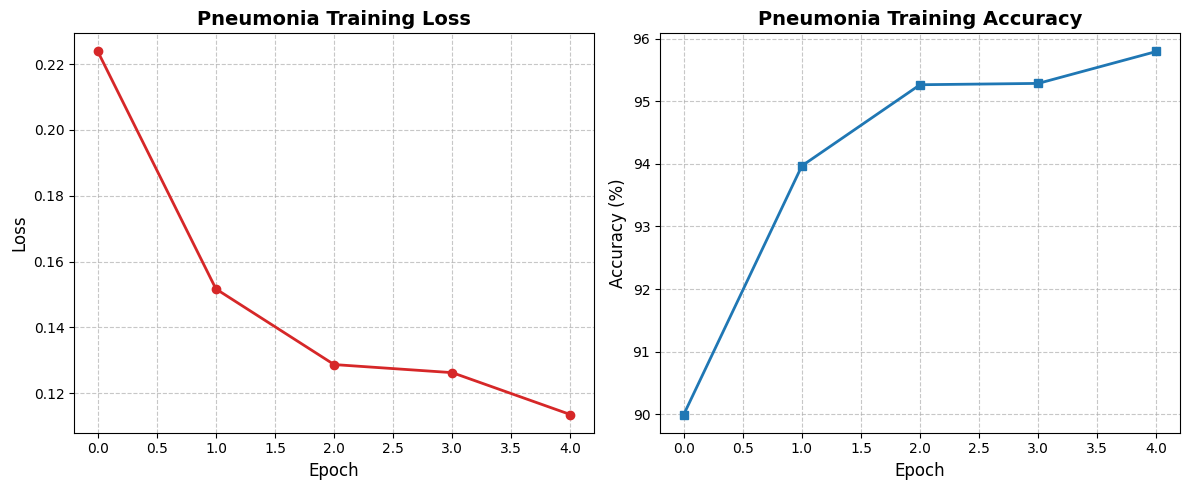

In [12]:
import os
# Save the Weights
weights_dir = os.path.join(DRIVE_PATH, 'model_weights')
os.makedirs(weights_dir, exist_ok=True)
save_path = os.path.join(weights_dir, 'pneumonia_vit_model.pth')
torch.save(model_pneu.state_dict(), save_path)
print(f"Pneumonia Model saved to: {save_path}")

plot_for_report(pneu_losses, pneu_accs, filename="/content/drive/MyDrive/amlData/graphs/pneumonia_training_graphs.png")

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

# ChestMNIST is big
train_loader_chest = DataLoader(train_dataset_chest, batch_size=32, shuffle=True)

# Initialize Model (14 Classes for 14 Diseases)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_chest = get_vit_model(num_classes=14).to(device)

# "BCEWithLogitsLoss" combines a Sigmoid layer and BCE Loss in one class
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_chest.heads.parameters(), lr=0.001)

num_epochs = 5
print(f"--- Starting Training for ChestMNIST (Multi-Label) ---")

for epoch in range(num_epochs):
    model_chest.train()
    running_loss = 0.0


    progress_bar = tqdm(train_loader_chest, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in progress_bar:
        images = images.to(device)

        # BCE Loss expects float targets (0.0 or 1.0)
        labels = labels.float().to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model_chest(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update bar with Loss only
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader_chest)
    print(f"Epoch {epoch+1} Final Loss: {epoch_loss:.4f}")

# Save Weights
weights_dir = os.path.join(DRIVE_PATH, 'model_weights')
os.makedirs(weights_dir, exist_ok=True)
save_path = os.path.join(weights_dir, 'chest_vit_model.pth')

torch.save(model_chest.state_dict(), save_path)
print(f"Chest Model saved to: {save_path}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 246MB/s]


--- Starting Training for ChestMNIST (Multi-Label) ---


Epoch 1/5: 100%|██████████| 2453/2453 [05:53<00:00,  6.95batch/s, loss=0.141]


Epoch 1 Final Loss: 0.1736


Epoch 2/5: 100%|██████████| 2453/2453 [05:52<00:00,  6.95batch/s, loss=0.168]


Epoch 2 Final Loss: 0.1694


Epoch 3/5: 100%|██████████| 2453/2453 [05:51<00:00,  6.98batch/s, loss=0.123]


Epoch 3 Final Loss: 0.1680


Epoch 4/5: 100%|██████████| 2453/2453 [05:52<00:00,  6.96batch/s, loss=0.0817]


Epoch 4 Final Loss: 0.1672


Epoch 5/5: 100%|██████████| 2453/2453 [05:52<00:00,  6.95batch/s, loss=0.185]


Epoch 5 Final Loss: 0.1666
Chest Model saved to: /content/drive/MyDrive/amlData/model_weights/chest_vit_model.pth
